In [61]:
import sys, os, argparse, time, numpy as np, tensorflow as tf, pandas as pd
"""
Do the following if using colab
1. Download this notebook and upload to colab as your entry point
2. Uncomment the code below
"""
#!git clone https://github.com/Temiloluwa/leo_segmentation.git --branch leo_maml_tensorflow
#os.chdir(os.path.join("./leo_segmentation")) 
from leo_segmentation.data import Datagenerator, TrainingStats
from leo_segmentation.model import LEO, load_model, save_model
from leo_segmentation.utils import load_config, check_experiment, get_named_dict, \
                        log_data, load_yaml, train_logger, val_logger, print_to_string_io, \
                        save_pickled_data, model_dir
from leo_segmentation.run import train_model
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Train Model

In [ ]:
dataset ="fss1000"
leo = train_model(config, dataset)

## Evaluation

In [25]:
mode = "meta_val"
dataset ="fss1000"
dataloader = Datagenerator(config, dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['dog', 'horse', 'diningtable', 'person', 'motorbike']


In [37]:
select_class = 1
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class horse is selected


In [38]:
#perform forward_propagate and perform innerloop updates to generate weights
seg_weight_grad, features = leo.leo_inner_loop(batch_data.tr_imgs, batch_data.tr_masks)
#fine tune the weights
tr_val_loss, seg_weight_grad, decoder_gradients, tr_prediction, weight = \
            leo.finetuning_inner_loop(batch_data, features, seg_weight_grad, mode)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = np.vstack([list_to_tensor(batch_data.val_imgs[i], img_transformer) \
                                 for i in pred_data_index])
    input_mask = np.vstack([list_to_tensor(batch_data.val_masks[i], mask_transformer) \
                            for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_imgs[pred_data_index], img_transformer)
    input_mask = list_to_tensor(batch_data.val_masks[pred_data_index], mask_transformer)

#predict on training data
encoder_outputs = leo.forward_encoder(input_embedding)
features = leo.forward_decoder(encoder_outputs)
val_prediction = leo.forward_segnetwork(features, input_embedding, weight)
val_prediction = np.argmax(val_prediction, -1) 

In [39]:
def plot_batch_mask(embeds, preds, masks):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow((embed+1)/2)
        plt.title("raw images")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

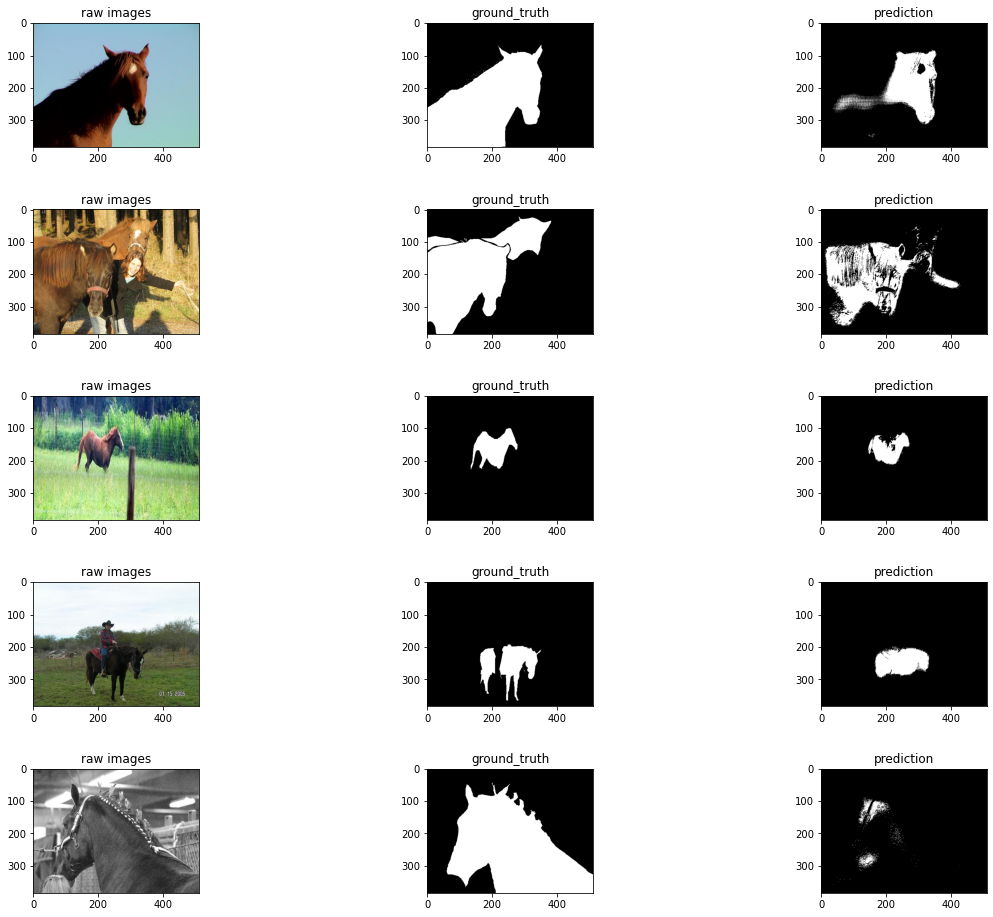

In [40]:
plot_batch_mask(input_embedding, val_prediction, input_mask)

In [8]:
experiment_number = config.experiment.number
experiment_description = config.experiment.description
experiment_root_path = os.path.join("leo_segmentation", "data", "models", f"experiment_{experiment_number}")
cached_files = os.listdir(experiment_root_path)
cached_files

['experiment_meta_test_5_ious.pkl',
 'experiment_meta_test_5_stats.pkl',
 'experiment_meta_train_5_ious.pkl',
 'experiment_meta_train_5_stats.pkl',
 'experiment_meta_val_5_ious.pkl',
 'experiment_meta_val_5_stats.pkl',
 'train_log.txt',
 'val_log.txt']

In [42]:
val_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[4])).T
filtered_scores = []
for _class, _df in val_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_val_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_val_ious", "class_sampling_frequency"])
filtered_val_ious = filtered_val_ious.sort_values(by="mean_val_ious", ascending=False)
filtered_val_ious

,classes,mean_val_ious,class_sampling_frequency
198,pspgo,0.911936,17
77,psp,0.908894,31
169,shih-tzu,0.903833,18
127,ringlet_butterfly,0.891758,27
180,pickup,0.891702,22
174,saltshaker,0.875955,22
160,persian_cat,0.875412,26
197,red_fox,0.872950,22
9,otter,0.863055,30
179,pumpkin,0.860213,29


In [52]:
filtered_val_ious.class_sampling_frequency.min()

14

In [54]:
train_ious = pd.read_pickle(os.path.join(experiment_root_path, cached_files[2])).T
filtered_scores = []
for _class, _df in train_ious.iterrows():
    if _class == "episode":
        continue
    temp = [i for i in _df if not np.isnan(i)]
    class_sampling_frequency = len(temp)
    mean_of_all_ious_per_class = np.mean(temp)
    filtered_scores.append((_class, mean_of_all_ious_per_class, class_sampling_frequency))
filtered_train_ious = pd.DataFrame(filtered_scores, columns=["classes", "mean_train_ious", "class_sampling_frequency"])
filtered_train_ious = filtered_train_ious.sort_values(by="mean_train_ious", ascending=False)
filtered_train_ious

,classes,mean_train_ious,class_sampling_frequency
551,battery,0.950365,4
586,brain_coral,0.938172,7
510,moist_proof_pad,0.937338,5
596,bee_house,0.935672,6
565,maraca,0.933538,6
397,doublebus,0.930998,9
554,afghan_hound,0.928004,5
410,digital_clock,0.927946,3
523,frying_pan,0.927098,9
220,coin,0.922588,7


In [72]:
#classes in meta-train and meta-val are unique if their intersection is zero
set(filtered_train_ious.classes.unique()).intersection(set(filtered_val_ious.classes.unique()))

set()

In [79]:
meta_val_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[5]))
num_data_points = meta_val_loss.shape[0]
meta_val_loss

,mode,episode,kl_loss,total_val_loss
0,meta_val,1,0,0.603483
1,meta_val,2,0,0.558829
2,meta_val,3,0,0.656672
3,meta_val,4,0,0.495517
4,meta_val,5,0,0.599853
5,meta_val,6,0,0.583001
6,meta_val,7,0,0.555940
7,meta_val,8,0,0.608502
8,meta_val,9,0,0.594787
9,meta_val,10,0,0.552867


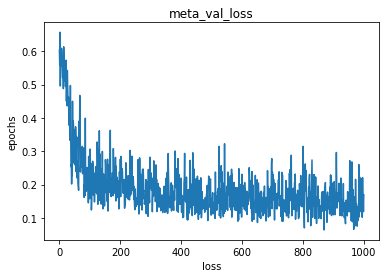

In [82]:
plt.title("meta_val_loss")
plt.ylabel("epochs")
plt.xlabel("loss")
plt.plot(np.arange(num_data_points), meta_val_loss.total_val_loss)

In [83]:
meta_train_loss = pd.read_pickle(os.path.join(experiment_root_path, cached_files[3]))
num_data_points = meta_train_loss.shape[0]
meta_train_loss

,mode,episode,kl_loss,total_val_loss
0,meta_train,1,0,0.766890
1,meta_train,2,0,0.623724
2,meta_train,3,0,0.539088
3,meta_train,4,0,0.599208
4,meta_train,5,0,0.741251
5,meta_train,6,0,0.542466
6,meta_train,7,0,0.544673
7,meta_train,8,0,0.598483
8,meta_train,9,0,0.552356
9,meta_train,10,0,0.563102


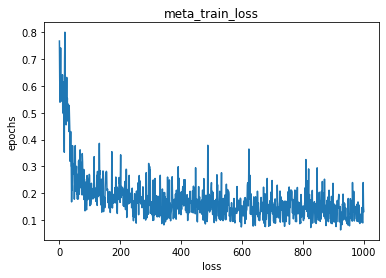

In [84]:
plt.title("meta_train_loss")
plt.ylabel("epochs")
plt.xlabel("loss")
plt.plot(np.arange(num_data_points), meta_train_loss.total_val_loss)